# Colombian Coffee Production Prediction

## Time Series Analysis

This sript will retrieve information from the .csv files saved on step 0 ([Loading Data](00_LoadingData.ipynb)) and perform a partial analysis using only Production Analysis shifted in time.

If step 0 ([Loading Data](00_LoadingData.ipynb)) has already been executed **once** it will not be necessary to execute it again.  For analysis purposes, it's also assumed tht step 1 ([EDA](01_EDA.ipynb)) has also been executed for a better understanding

In [16]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import linear_model
from sklearn import model_selection

**Load Clean Monthly Data**

In [65]:
pd.set_option('display.max_rows',50)
matplotlib.rcParams["figure.figsize"] = (20, 10)

coffee_df=pd.read_csv('../csv/FINAL_coffee_mth.csv', index_col=0)
len(coffee_df)

98

**Transforming Data**

Create new Column in date format to use in Time Analysis

In [66]:
coffee_df['month_dt'] = pd.to_datetime((coffee_df["year"].map(str) + " " + coffee_df["month"] + ' 01'),infer_datetime_format=True)
coffee_df.head()

,Produccion,year,month,avg_precip,avg_tmp,avg_wind,dew_point,avg_humidity,colombia_price,brasil_price,...,month[T.March],month[T.May],month[T.June],month[T.July],month[T.August],month[T.September],month[T.October],month[T.November],month[T.December],month_dt
0,515.0,2010,January,0.0,73,1,64,69.625000,207.51,131.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01
1,648.0,2010,February,0.0,76,1,64,70.153846,204.71,124.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-02-01
2,629.0,2010,March,0.0,75,1,65,68.500000,205.71,126.21,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-03-01
3,647.0,2010,April,0.0,73,1,66,78.375000,199.50,125.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-04-01
4,822.0,2010,May,0.0,74,1,66,76.703704,200.33,127.32,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-05-01


**Plot general Time Series**

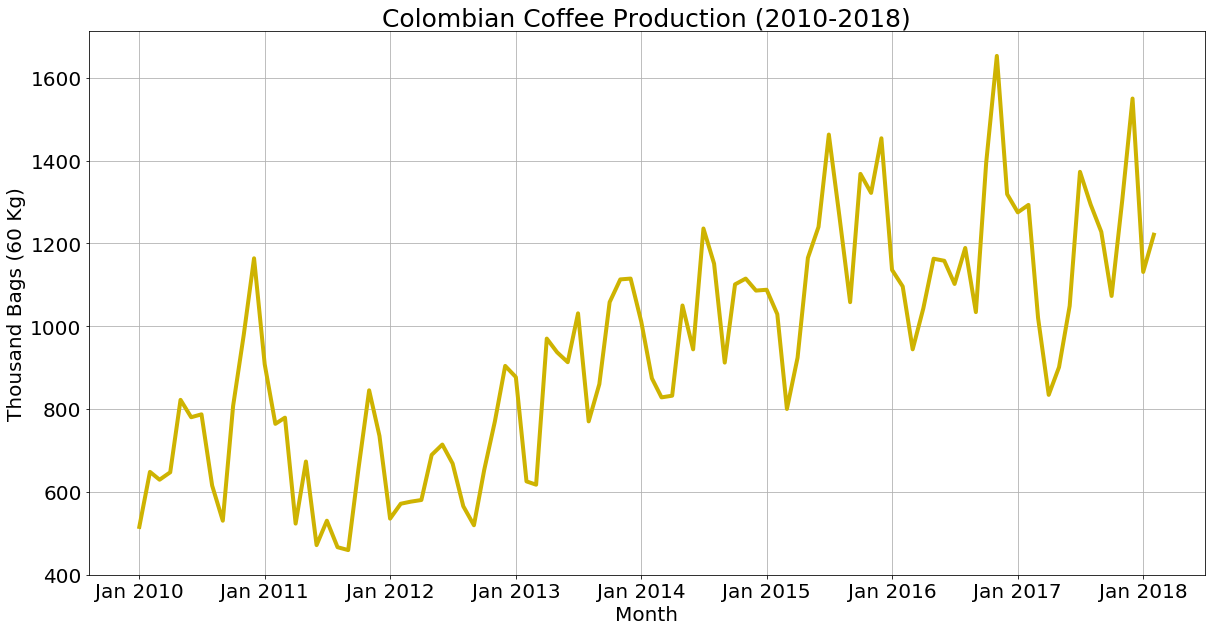

In [67]:
fig, ax = plt.subplots()

ax.plot(coffee_df['month_dt'], coffee_df['Produccion'], linewidth=4, color='xkcd:mustard')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Colombian Coffee Production (2010-2018)', fontsize=25)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Thousand Bags (60 Kg)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(True)

plt.savefig('../graphs/TimeSeries_Initial.png')

**Create new column with previous month's Production**

In [29]:
full_time_df = pd.DataFrame(coffee_df[['month_dt','Produccion']])
full_time_df['prev_month'] = full_time_df['Produccion'].shift()
full_time_df = full_time_df.dropna()  #First row

full_time_df.head()

,month_dt,Produccion,prev_month
1,2010-02-01,648.0,515.0
2,2010-03-01,629.0,648.0
3,2010-04-01,647.0,629.0
4,2010-05-01,822.0,647.0
5,2010-06-01,780.0,822.0


**Split data set: Train test will be years 2010-2017 and test set: 2018**

In [45]:
time_df = full_time_df.iloc[:-3,:]
col_x = time_df.dropna()[["prev_month"]]
col_y = time_df.dropna()[["Produccion"]]

pred18_df = full_time_df.iloc[-3:,:]

len(time_df)

94

**Make a quick first Linear Regression Model**

In [32]:
model = linear_model.LinearRegression()
model.fit(col_x, col_y)
model.coef_, model.intercept_, model.score(col_x,col_y)

(array([[0.81862474]]), array([176.74265826]), 0.6736871894448311)

R2 value for our train data seems fair enough (0.674)

**Plot this model's prediction against real values**

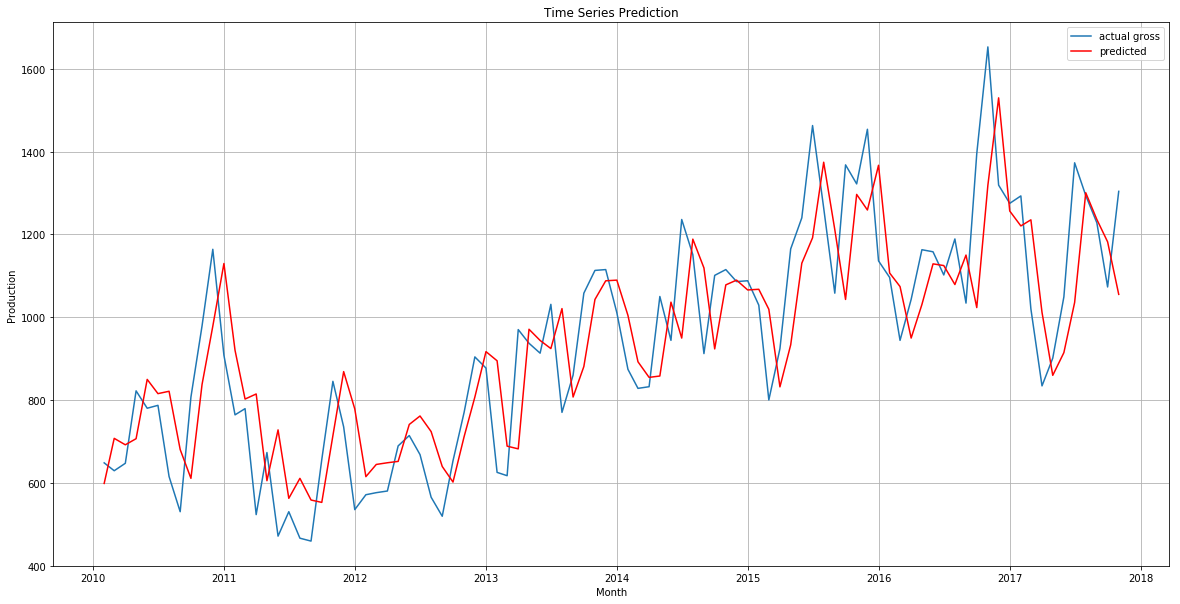

In [68]:
# plot actuals and predicted

x = coffee_df['month_dt'][1:-3]
y_true = col_y['Produccion']
plt.plot(x,y_true, label="actual gross")

y_pred = model.predict(col_x)
plt.plot(x,y_pred, color='red', label="predicted")

plt.title("Time Series Prediction")
plt.xlabel("Month")
plt.ylabel("Production")
plt.grid()
plt.legend()

plt.savefig('../graphs/TimeSeries_PredictTrain.png')

**With this Model, get prediction for 2018 data**

In [46]:
y18_pred = model.predict(pred18_df[['prev_month']])
y18_pred

array([[1244.22932196],
       [1445.61100851],
       [1102.60724158]])

**Also get prediction for future unkown data**

In [47]:
pred18_df

,month_dt,Produccion,prev_month
95,2017-12-01,1550.0,1304.0
96,2018-01-01,1131.0,1550.0
97,2018-02-01,1221.0,1131.0


In [48]:
#Real value for February was 1221, so we'll make the prediction on that value for march
future_x=pd.DataFrame([1221])
future_y=model.predict(future_x)
future_y

array([[1176.28346836]])

In [49]:
model.score(pred18_df[['prev_month']],pred18_df[['Produccion']])

-1.122211969865314

**Plot trainig data and test prediction points**

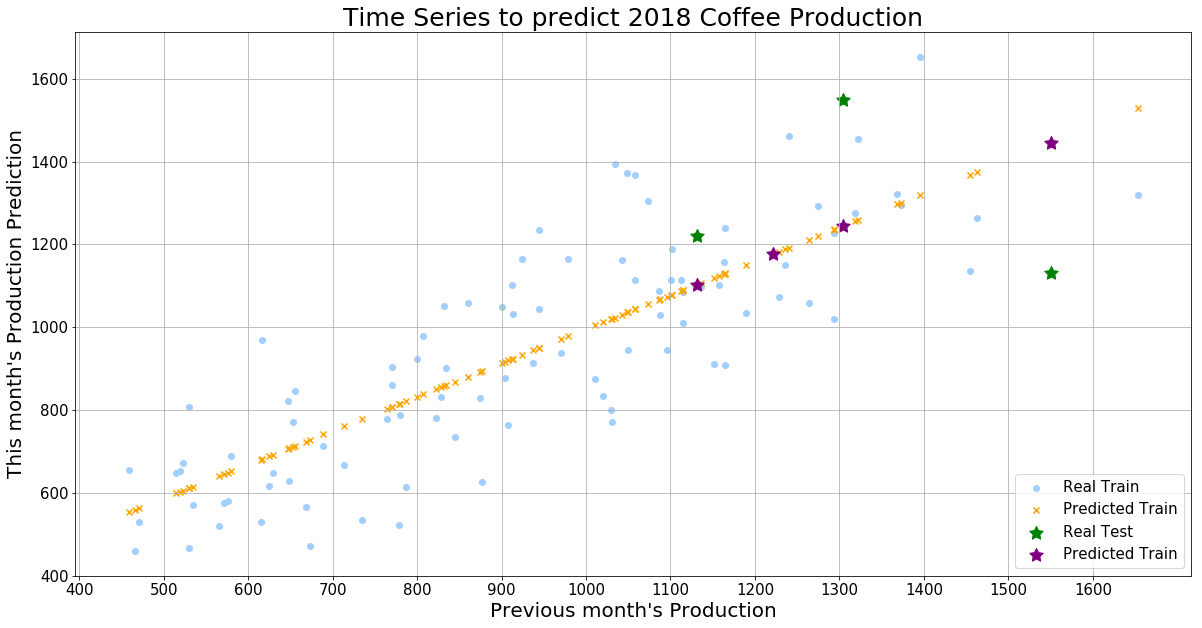

In [69]:
# Plot Real training data (2010-2017)
plt.scatter(time_df.prev_month, col_y['Produccion'], color='xkcd:baby blue', label='Real Train')

# Plot Predicted values for training set (2010-2017)
plt.scatter(time_df.prev_month, y_pred, color='orange', marker='x', label='Predicted Train')

# Plot Real test data (2018)
plt.scatter(pred18_df['prev_month'], pred18_df['Produccion'], color='green', marker=(5,1), s=200, label='Real Test')

# Plot Predicted values for test set (2018)
plt.scatter(pred18_df['prev_month'], y18_pred, color='purple', marker=(5, 1), s=200, label='Predicted Train')

# Plot Predicted values for (April 2018)
plt.scatter(future_x, future_y, color='purple', marker=(5, 1), s=200)

plt.title('Time Series to predict 2018 Coffee Production',fontsize=25)
plt.xlabel("Previous month's Production", fontsize=20)
plt.ylabel("This month's Production Prediction", fontsize=20)
plt.legend(loc='lower right', fontsize=15)
plt.xticks(range(400,1700,100), fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

plt.savefig('../graphs/TimeSeries_PredictFull.png')

**Conclusions**

Coffee Production for previous month seems to have an impact on current month's data.  This variable will need to be included in the final set for further analysis.

In [51]:
merge_df = pd.merge(coffee_df, full_time_df, how='inner', on=['month_dt'])
merge_df.columns

Index(['Produccion_x', 'year', 'month', 'avg_precip', 'avg_tmp', 'avg_wind',
       'dew_point', 'avg_humidity', 'colombia_price', 'brasil_price',
       'others_price', 'vol_export', 'trm', 'Intercept', 'month[T.January]',
       'month[T.February]', 'month[T.March]', 'month[T.May]', 'month[T.June]',
       'month[T.July]', 'month[T.August]', 'month[T.September]',
       'month[T.October]', 'month[T.November]', 'month[T.December]',
       'month_dt', 'Produccion_y', 'prev_month'],
      dtype='object')

In [70]:
coffee_df = merge_df[['Produccion_x', 'avg_precip', 'avg_tmp',
       'avg_wind', 'dew_point', 'avg_humidity', 'colombia_price',
       'brasil_price', 'others_price', 'vol_export', 'trm', 'Intercept',
       'month[T.January]', 'month[T.February]', 'month[T.March]',
       'month[T.May]', 'month[T.June]', 'month[T.July]', 'month[T.August]',
       'month[T.September]', 'month[T.October]', 'month[T.November]',
       'month[T.December]', 'prev_month']]
coffee_df= coffee_df.rename(columns={'Produccion_x':'Produccion'})
coffee_df.to_csv('../csv/FINAL_coffee_mth_final.csv')